In [ ]:
!pip install pyspark==3.0.1 py4j==0.10.9


Для выполнения работы можно использовать любой датасет. С помощью PySpark выполнить:
# 1.Статистический анализ данных.

Импорт нужных библиотек

In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import min, mean, max
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt
import pandas as pd

Создаём спарк-сессию с нашим именем и выделяем ему память через контекст

In [ ]:
#создаём спарк сессею
sc = SparkContext(conf=SparkConf().setAppName("Praktika PySpark"). set("spark.executor.memory", "2g"))
spark = SparkSession(sc)
spark

Считаем наш датасет

In [ ]:
data = spark.read.format("csv")\
        .option("header", "true")\
        .option("delimiter", ",")\
        .option("inferSchema", "true")\
        .load('/content/greenhouse_gas_inventory_data_data.csv')
data.show()

+---------------+----+----------------+--------------------+
|country_or_area|year|           value|            category|
+---------------+----+----------------+--------------------+
|      Australia|2014|393126.946994288|carbon_dioxide_co...|
|      Australia|2013| 396913.93653029|carbon_dioxide_co...|
|      Australia|2012|  406462.8477036|carbon_dioxide_co...|
|      Australia|2011|403705.528313991|carbon_dioxide_co...|
|      Australia|2010|406200.993184341|carbon_dioxide_co...|
|      Australia|2009| 408448.47899963|carbon_dioxide_co...|
|      Australia|2008|404237.828214077|carbon_dioxide_co...|
|      Australia|2007|398816.453543549|carbon_dioxide_co...|
|      Australia|2006|391134.100909449|carbon_dioxide_co...|
|      Australia|2005|385581.132806466|carbon_dioxide_co...|
|      Australia|2004|381519.261592783|carbon_dioxide_co...|
|      Australia|2003|368345.977425107|carbon_dioxide_co...|
|      Australia|2002|361861.387896028|carbon_dioxide_co...|
|      Australia|2001|35

Проведем анализ по данным, что у нас есть на то, какие переменные, есть ли дубли, полное количество строк, посмотрим на средние значения и отклонения, попробуем сгруппировать данные по странам и году и посмотреть на полученный результат

In [ ]:
data.printSchema()

root
 |-- country_or_area: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- value: double (nullable = true)
 |-- category: string (nullable = true)



In [ ]:
data.select().count()

8406

In [ ]:
data.describe().show()

+-------+--------------------+------------------+------------------+--------------------+
|summary|     country_or_area|              year|             value|            category|
+-------+--------------------+------------------+------------------+--------------------+
|  count|                8406|              8406|              8406|                8406|
|   mean|                null|2002.1884368308351|205547.19137087325|                null|
| stddev|                null| 7.151604788310116| 804150.3770358328|                null|
|    min|           Australia|              1990|        1.10375E-6|carbon_dioxide_co...|
|    max|United States of ...|              2014|  7422207.96295139|unspecified_mix_o...|
+-------+--------------------+------------------+------------------+--------------------+



Проведем группировку данных по стране и году

In [ ]:
grouped_data_country = data.groupBy("country_or_area").agg(mean("value").alias("avg_value"))
grouped_data_year = data.groupBy("year").agg(mean("value").alias("avg_value"))

In [ ]:
grouped_data_country.orderBy("avg_value").show()

+---------------+------------------+
|country_or_area|         avg_value|
+---------------+------------------+
|         Monaco| 41.08254467107348|
|  Liechtenstein| 73.85859172266156|
|          Malta|  1156.90364453068|
|        Iceland|1538.5653407189286|
|         Cyprus|3532.1542142249637|
|     Luxembourg| 3833.000463738608|
|         Latvia| 6065.848190234436|
|       Slovenia| 7401.164440337049|
|        Estonia| 9042.185919429108|
|      Lithuania|10896.219409193256|
|        Croatia|10979.664146628964|
|    Switzerland|19194.737784888333|
|       Slovakia| 19824.65335161888|
|         Norway|20169.325243725376|
|       Bulgaria|21622.049086484712|
|        Ireland| 22056.18632281963|
|         Sweden| 25393.44242086523|
|        Finland|27119.721266121833|
|        Denmark| 27347.10202685046|
|        Hungary|27850.240821012918|
+---------------+------------------+
only showing top 20 rows



Как видим, Монако и Лихтеншейн в лидерах, их среднее значение по наличию природного газа минимальное, вероятно это связано с размером стран

Отсортируем по году и нарисуем график, чтобы посмотреть как идет изменение относительно времени

In [ ]:
grouped_data_year.orderBy("year").show()

+----+------------------+
|year|         avg_value|
+----+------------------+
|1990|  241247.761879809|
|1991|233382.41474832976|
|1992|222868.45669692315|
|1993|218740.39979051365|
|1994| 212603.1880181515|
|1995| 205569.0409002538|
|1996|208074.76774199284|
|1997|204968.89303152295|
|1998|203379.77877342995|
|1999| 201396.2471409284|
|2000|202954.84062516456|
|2001| 202533.0476694843|
|2002| 202507.2563167111|
|2003|205392.55136759122|
|2004|207367.67381894976|
|2005|207371.77631833474|
|2006|206890.55162788607|
|2007| 207704.8020484204|
|2008| 202172.3482385217|
|2009|189498.28811882078|
+----+------------------+
only showing top 20 rows



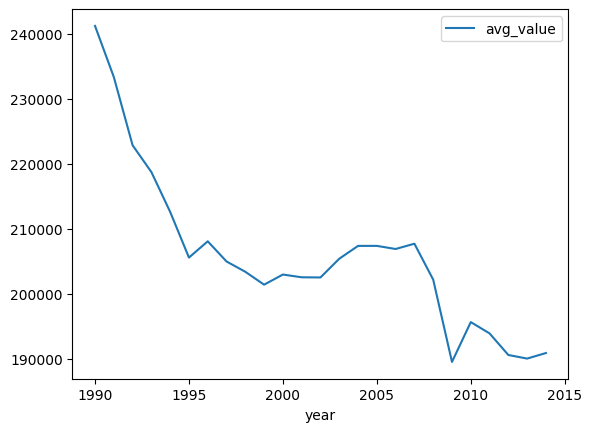

In [ ]:
pdf = grouped_data_year.orderBy("year").toPandas().plot(x="year", y="avg_value")
plt.show()

# 2.Корреляционный анализ.

Так как числовых переменных всего две, то матрицу построить не имеет смысла, корреляция между двумя столбцами в PySpark делается просто

In [ ]:
data.stat.corr("year", "value")


-0.01247978176331368

Как видим, в данных датасета достаточно слабый уровень корреляции значения природного газа от года, даже на графике выше видно, что уровень в зависимости от года не постепенно снижается, а происходят рывки


# 3.Применить модель машинного обучения для решения задачи регрессии или классификации

Будем предсказывать (зависимая переменная) - колонку value

In [ ]:
stages = []
label_stringIdx = StringIndexer(inputCol = 'value', outputCol = 'label', handleInvalid = 'keep')
stages += [label_stringIdx]


Она будет зависеть от категориальных перменных - страны и типа загрязнения (country_or_area, category), будем преобразовывать их в бинарные вектора, благодаря PySpark

In [ ]:
categoricalColumns = ['country_or_area', 'category']
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol,
                                  outputCol = categoricalCol + 'Index',
                                  handleInvalid = 'keep')
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(),
                            outputCol=categoricalCol + "classVec")
    stages += [stringIndexer, encoder]


Нужна зависимость от числового столбца, в нашем случае - это year, и поток сделаем отдельную вектор колонку, как в примере для матрицы корреляции (хотя у нас и без неё обошлось)

In [ ]:
numericCols = ['year']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

Разделим наш датасет на тренировочную и тестовую выборку в соотношении 80% к 20% соответственно и выучим модель с помощью градиентного регрессионого дерева бустинга (GBTRegressor), который должен предсказывать весь вектор «label» по признакам, которые мы объединили в отдельную колонку «features» с ограничением по итерируемости 10

In [ ]:
(trainingData, testData) = data.randomSplit([0.8, 0.2])

gbt = GBTRegressor(labelCol="label", featuresCol="features", maxIter=10)
stages += [gbt]

pipeline = Pipeline(stages=stages)

model = pipeline.fit(trainingData)

predictions = model.transform(testData)

In [ ]:
predictions.show()

+---------------+----+----------------+--------------------+------+--------------------+-----------------------+-------------+----------------+--------------------+------------------+
|country_or_area|year|           value|            category| label|country_or_areaIndex|country_or_areaclassVec|categoryIndex|categoryclassVec|            features|        prediction|
+---------------+----+----------------+--------------------+------+--------------------+-----------------------+-------------+----------------+--------------------+------------------+
|      Australia|1990|      1424.68352|hydrofluorocarbon...|1573.0|                26.0|        (43,[26],[1.0])|          5.0|  (10,[5],[1.0])|(54,[26,48,53],[1...|3279.2499583758317|
|      Australia|1990|118768.837813046|methane_ch4_emiss...|6288.0|                26.0|        (43,[26],[1.0])|          2.0|  (10,[2],[1.0])|(54,[26,45,53],[1...|3445.1290384071626|
|      Australia|1991|4610.74329393256|perfluorocarbons_...|6288.0|             

In [ ]:
evaluator = RegressionEvaluator(labelCol='value', predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 856926.9817578755


# 4.Применить модель машинного обучения для решения задачи кластеризации.

In [ ]:
data = spark.read.format("csv")\
        .option("header", "true")\
        .option("delimiter", ",")\
        .option("inferSchema", "true")\
        .load('/content/greenhouse_gas_inventory_data_data.csv')

In [ ]:
selected_features = ["year", "value"]
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
data = assembler.transform(data)
kmeans = KMeans().setK(5).setSeed(1)
model = kmeans.fit(data)
predictions = model.transform(data)
predictions.select("year", "value", "prediction").show()

+----+----------------+----------+
|year|           value|prediction|
+----+----------------+----------+
|2014|393126.946994288|         4|
|2013| 396913.93653029|         4|
|2012|  406462.8477036|         4|
|2011|403705.528313991|         4|
|2010|406200.993184341|         4|
|2009| 408448.47899963|         4|
|2008|404237.828214077|         4|
|2007|398816.453543549|         4|
|2006|391134.100909449|         4|
|2005|385581.132806466|         4|
|2004|381519.261592783|         4|
|2003|368345.977425107|         4|
|2002|361861.387896028|         4|
|2001|357653.329899303|         4|
|2000|349885.433108928|         4|
|1999|343713.906947774|         4|
|1998|334328.142646602|         0|
|1997|320439.116819391|         0|
|1996|311914.819824229|         0|
|1995|305162.543548735|         0|
+----+----------------+----------+
only showing top 20 rows



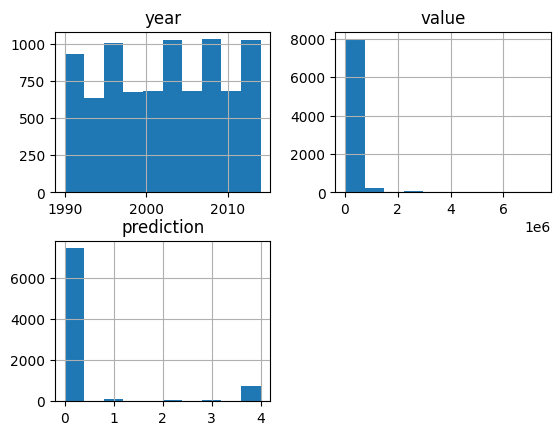

In [ ]:
predictions.select("year", "value", "prediction").toPandas().hist()
None